In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py
import MAS_library as MASL
import Pk_library as PKL
import mass_function_library as MFL
import functions as fn
import Box
import myRCParams

In [2]:
z = 2
grid = 1024
MAS = 'CIC'
verbose = True

In [3]:
box = Box.Box(fn.box_path, fn.shot[z])
box.coords_gas = (box.coords_gas / 1e3).astype(np.float32)
box.coords_DM = (box.coords_DM / 1e3).astype(np.float32)
box.coords_stars = (box.coords_stars / 1e3).astype(np.float32)
box.size = (box.size / 1e3).astype(np.float32)
box.mass_gas = (box.mass_gas  * 1e10).astype(np.float32)
box.mass_DM = (box.mass_DM * 1e10).astype(np.float32)
box.mass_stars = (box.mass_stars * 1e10).astype(np.float32)

BoxSize = box.size

In [4]:
#create overdensity field
def density(coords, mass):
    global grid
    global BoxSize     #Mpc/h
    global MAS
    global verbose

    #define 3d density field
    delta = np.zeros((grid, grid, grid), dtype=np.float32)

    #construct 3d density field
    MASL.MA(coords, delta, BoxSize, MAS, W=mass, verbose=verbose)

    #turn into overdensity field
    delta /= np.mean(delta, dtype=np.float64)
    delta -= 1.0
    
    return delta

In [5]:
#create power spectrum
def power_spec(delta):
    threads = 8
    axis = 0
    
    global grid
    global BoxSize     #Mpc/h
    global MAS
    global verbose
    
    #compute power spectrum
    Pk = PKL.Pk(delta, BoxSize, axis, MAS, threads, verbose)

    k = Pk.k3D             #(Mpc/h)^-1
    Pk0 = Pk.Pk[:,0]       #(Mpc/h)^-3
    Nmodes = Pk.Nmodes3D
    return Pk0, k, Nmodes

In [6]:
#total mass of each component
m_DM = np.sum(box.mass_DM)
m_gas = np.sum(box.mass_gas)
m_stars = np.sum(box.mass_stars)
m = m_DM + m_gas + m_stars
#density parameter Omega of each component
omega_DM = m_DM / m
omega_gas = m_gas / m
omega_stars = m_stars / m


In [7]:
#create power spectrum for each component
delta_DM = density(box.coords_DM, box.mass_DM)
delta_gas = density(box.coords_gas, box.mass_gas)
delta_stars = density(box.coords_stars, box.mass_stars)
delta_tot = (delta_DM*omega_DM + delta_gas*omega_gas + delta_stars*omega_stars)

Pk0_DM, k_DM, N_modes_DM = power_spec(delta_DM)
Pk0_gas, k_gas, N_modes_gas = power_spec(delta_gas)
Pk0_stars, k_stars, N_modes_stars = power_spec(delta_stars)
Pk0_tot, k_tot, N_modes_tot = power_spec(delta_tot)

#combine into one array
Pk0 = np.array([Pk0_DM, Pk0_gas, Pk0_stars])
k = np.array([k_DM, k_gas, k_stars])
N_modes = np.array([N_modes_DM, N_modes_gas, N_modes_stars])



Using CIC mass assignment scheme with weights
Time taken = 7.918 seconds


Using CIC mass assignment scheme with weights
Time taken = 7.873 seconds


Using CIC mass assignment scheme with weights
Time taken = 0.901 seconds


Computing power spectrum of the field...
Time to complete loop = 44.84
Time taken = 50.14 seconds

Computing power spectrum of the field...
Time to complete loop = 44.87
Time taken = 50.10 seconds

Computing power spectrum of the field...
Time to complete loop = 45.01
Time taken = 50.39 seconds

Computing power spectrum of the field...
Time to complete loop = 45.92
Time taken = 51.17 seconds


In [8]:
with open(fn.here_path/'Power_Spectra'/f'box_total_z{z}.csv', 'w') as f:
    f.write('k, P(k)')
    np.savetxt(f, np.c_[k_tot.T, Pk0_tot.T], delimiter=',')

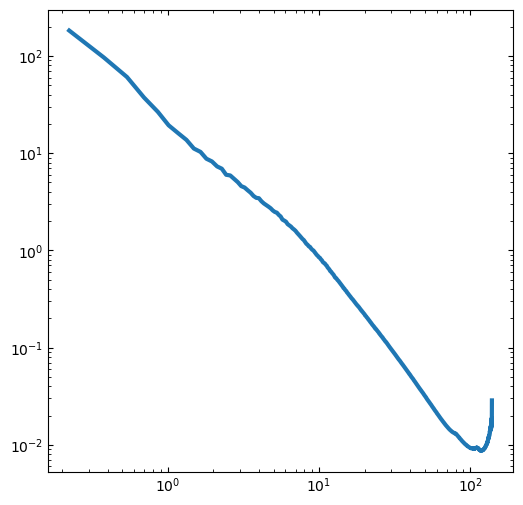

In [9]:
plt.loglog(k_tot, Pk0_tot, lw=3)